In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
print(f"Torch: {torch.__version__}")

import gc

gc.collect()

torch.cuda.empty_cache()

# Training settings
batch_size = 16
epochs = 2
lr = 1e-5
gamma = 0.7
seed = 42



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'


train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(120),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)





Torch: 1.13.0+cu116


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/NEW_DATASET/TRAIN',
#                                                  target_size = (224, 224),
#                                                  batch_size = 32,
#                                                  class_mode = 'categorical')

# test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/NEW_DATASET/TEST',
#                                             target_size = (224, 224),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')

In [10]:
import torch
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/WAR misinformation/Final Dataset/16Jan_target/train'
val_dir = '/content/drive/MyDrive/WAR misinformation/Final Dataset/16Jan_target/val'
test_dir = '/content/drive/MyDrive/WAR misinformation/Final Dataset/16Jan_target/test'

train_img_data = torchvision.datasets.ImageFolder(train_dir,
                                            transform=train_transforms,
                                            )

val_img_data = torchvision.datasets.ImageFolder(val_dir,
                                            transform=val_transforms,
                                            )
test_img_data = torchvision.datasets.ImageFolder(test_dir,
                                            transform=test_transforms,
                                            )
 
train_data_loader = torch.utils.data.DataLoader(train_img_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_img_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_img_data, batch_size=batch_size, shuffle=True)



print(len(train_data_loader.dataset))
print(len(val_data_loader.dataset))
print(len(test_data_loader.dataset))


2913
570
636


In [11]:
!pip -q install timm
import timm
#torch.hub.list('pytorch/vision')
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
#model.fc.out_features = 12
#model.to(device)

import json
from PIL import Image
import torch
from torchvision import transforms

device = 'cuda'

model = timm.create_model('inception_v3', pretrained=True, num_classes=3).to(device)




In [12]:
torch.cuda.get_device_name(device=None)

'Tesla T4'

In [13]:

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    #for data, label in tqdm(train_loader):
    for data, label in tqdm(train_data_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_data_loader)
        epoch_loss += loss / len(train_data_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_data_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_data_loader)
            epoch_val_loss += val_loss / len(val_data_loader)
            
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    torch.save(model, './xception.pt')  

  0%|          | 0/183 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3253 - acc: 0.4064 - val_loss : 1.1012 - val_acc: 0.5049



  0%|          | 0/183 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.0771 - acc: 0.5352 - val_loss : 1.0337 - val_acc: 0.5747



In [15]:
model.eval()
prob_all = []
lable_all = []
prob_score=[]
i=0
for data, label in tqdm(test_data_loader):
        data = data.to(device)
        label = label.to(device)
        l2 = label.cpu().detach().numpy()
        lable_all.extend(l2)
        prob = model(data) 
        prob = prob.cpu().detach().numpy() 
        prob_score.extend(prob) 
        prob_all.extend(np.argmax(prob,axis=1)) 
        i=i+1
#print(prob_all)
#print(label_train)
print(i)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

target_names = ['1','2','3']

print("Accuracy:{:.4f}".format(accuracy_score(lable_all, prob_all) ))
print("Recall:{:.4f}".format(recall_score(lable_all, prob_all,average='macro') ))
print("Precision:{:.4f}".format(precision_score(lable_all, prob_all,average='macro') ))
print("f1_score:{:.4f}".format(f1_score(lable_all, prob_all,average='macro') ))
print(classification_report(lable_all,prob_all,target_names=target_names,digits=4))

#fpr, tpr, thresholds = roc_curve(lable_all, prob_score, pos_label=2)
#print("Auc:{:.4f}".format(roc_auc_score(lable_all, prob_score,average='macro') ))
print(confusion_matrix(prob_all,lable_all))

  0%|          | 0/40 [00:00<?, ?it/s]

40
Accuracy:0.5425
Recall:0.4521
Precision:0.4638
f1_score:0.4558
              precision    recall  f1-score   support

           1     0.6514    0.7091    0.6790       361
           2     0.3382    0.3309    0.3345       139
           3     0.4019    0.3162    0.3539       136

    accuracy                         0.5425       636
   macro avg     0.4638    0.4521    0.4558       636
weighted avg     0.5296    0.5425    0.5342       636

[[256  72  65]
 [ 62  46  28]
 [ 43  21  43]]


[Text(0.5, 0, '1'), Text(1.5, 0, '2'), Text(2.5, 0, '3')]

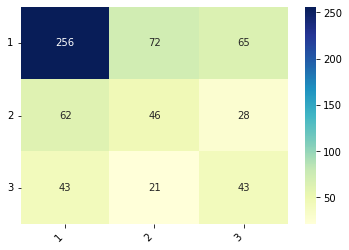

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_mat=confusion_matrix(prob_all,lable_all)
class_label=train_img_data.classes
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
df_cm
#conf_mat
heatmap=sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45, ha='right')

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, sampler, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for data, label in tqdm(iterator):
            data = data.to(device)
            #label = label.to(device)
            l2 = label.cpu().detach().numpy()
            lable_all.extend(l2)
            prob = model(data) 
            outputs.append(prob.cpu())
            labels.append(label)
        

    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

outputs, labels = get_representations(model, train_data_loader)


  0%|          | 0/183 [00:00<?, ?it/s]

In [19]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [20]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

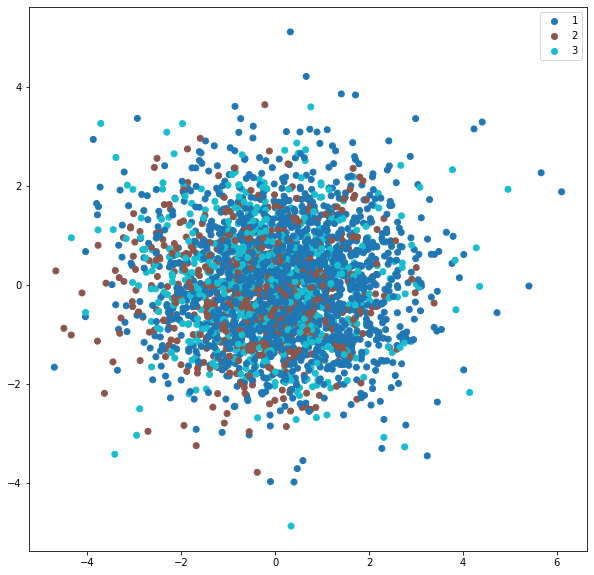

In [21]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, train_img_data.classes)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


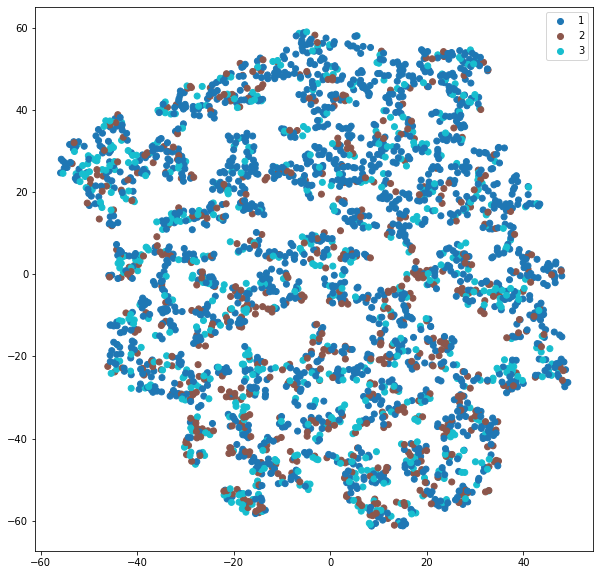

In [22]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, early_exaggeration=3, random_state = 8, perplexity=35,learning_rate=300)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, train_img_data.classes)

In [23]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:]

(770,
 ['adv_inception_v3',
  'bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_224_in22k',
  'beit_base_patch16_384',
  'beit_large_patch16_224',
  'beit_large_patch16_224_in22k',
  'beit_large_patch16_384',
  'beit_large_patch16_512',
  'beitv2_base_patch16_224',
  'beitv2_base_patch16_224_in22k',
  'beitv2_large_patch16_224',
  'beitv2_large_patch16_224_in22k',
  'botnet26t_256',
  'cait_m36_384',
  'cait_m48_448',
  'cait_s24_224',
  'cait_s24_384',
  'cait_s36_384',
  'cait_xs24_384',
  'cait_xxs24_224',
  'cait_xxs24_384',
  'cait_xxs36_224',
  'cait_xxs36_384',
  'coat_lite_mini',
  'coat_lite_small',
  'coat_lite_tiny',
  'coat_mini',
  'coat_tiny',
  'coatnet_0_rw_224',
  'coatnet_1_rw_224',
  'coatnet_bn_0_rw_224',
  'coatnet_nano_rw_224',
  'coatnet_rmlp_1_rw_224',
  'coatnet_rmlp_2_rw_224',
  'coatnet_rmlp_nano_rw_224',
  'coatnext_nano_rw_224',
  'convit_base',
  'convit_small',
  'convit_tiny',
  'convmixer_768_32',
  'convmixer_1024_20_ks9_p14',
  'convm